# Toy model for estimation of connectivity in MOU process

This Python notebook estimates the connectivity matrix from the observed activity generated by a MOU process.

In [1]:
# install the pyMOU library using pip
! pip install git+https://github.com/MatthieuGilson/pyMOU.git@master

  Cloning https://github.com/MatthieuGilson/pyMOU.git (to revision master) to /private/var/folders/kp/r23xdw651klchdzh0p6kj7240000gn/T/pip-req-build-06unt49b
    100% |████████████████████████████████| 13.9MB 56kB/s eta 0:00:011
    100% |████████████████████████████████| 27.7MB 144kB/s ta 0:00:011  25% |████████▎                       | 7.2MB 629kB/s eta 0:00:33    88% |████████████████████████████▍   | 24.6MB 309kB/s eta 0:00:11    89% |████████████████████████████▌   | 24.7MB 392kB/s eta 0:00:08    98% |███████████████████████████████▌| 27.3MB 441kB/s eta 0:00:02
    100% |████████████████████████████████| 14.4MB 160kB/s ta 0:00:011  47% |███████████████▎                | 6.9MB 449kB/s eta 0:00:17
    100% |████████████████████████████████| 10.6MB 161kB/s ta 0:00:01    58% |██████████████████▊             | 6.2MB 589kB/s eta 0:00:08    70% |██████████████████████▌         | 7.5MB 568kB/s eta 0:00:06
    100% |████████████████████████████████| 71kB 281kB/s ta 0:00:01
    100% |██████

In [11]:
import os
import numpy as np
import scipy.linalg as spl
import scipy.stats as stt
from pyMOU.MOU_model import MOU
import pyMOU.tools as tools
import matplotlib.pyplot as plt

## Simulation

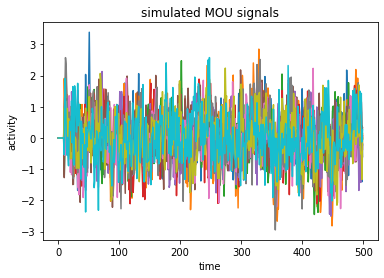

In [12]:
N = 10 # number of nodes
d = 0.3 # density of connectivity
# generate random matrix
C_orig = tools.make_rnd_connectivity(N, density=d, w_min=0.5/N/d, w_max=1.0/N/d)

# create MOU process
mou_orig = MOU(C_orig)

T = 500 # time in seconds
# simulate
ts_sim = mou_orig.simulate(T)

# plots
plt.figure()
plt.plot(range(T),ts_sim)
plt.xlabel('time')
plt.ylabel('activity')
plt.title('simulated MOU signals')

plt.show()

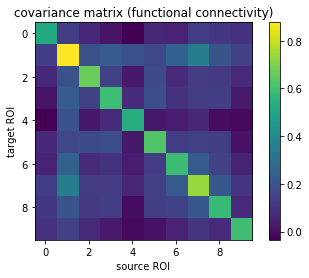

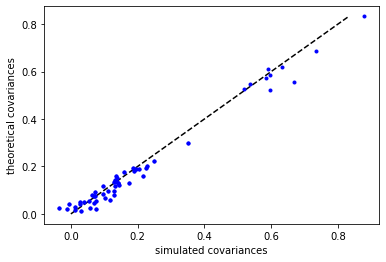

In [13]:
Q_sim = np.tensordot(ts_sim,ts_sim,axes=(0,0)) / (T-1)

J = -np.eye(N) + C_orig
Sigma = np.eye(N)
Q_th = spl.solve_continuous_lyapunov(J,-Sigma)


# plots
plt.figure()
plt.imshow(Q_sim)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('covariance matrix (functional connectivity)')

plt.figure()
plt.plot([0,Q_th.max()],[0,Q_th.max()],'--k')
plt.plot(Q_sim,Q_th,'.b')
plt.xlabel('simulated covariances')
plt.ylabel('theoretical covariances')

plt.show()

## Connectivity estimation

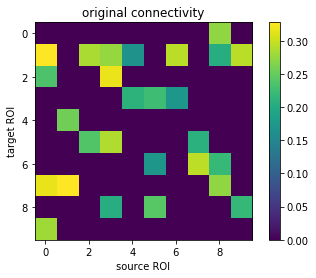

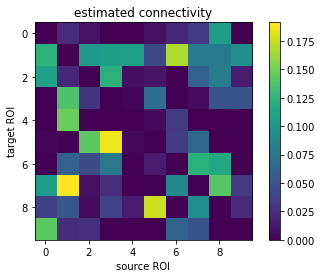

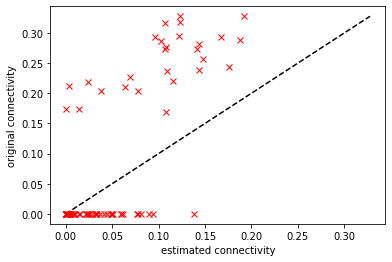

In [14]:
# Lyapunov optimization
mou_est = MOU()
mou_est.fit(ts_sim, regul_C=1.)

C_est = mou_est.get_C()


# plots
plt.figure()
plt.imshow(C_orig,vmin=0)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('original connectivity')

plt.figure()
plt.imshow(C_est,vmin=0)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('estimated connectivity')

plt.figure()
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.plot(C_est,C_orig,'xr')
plt.xlabel('estimated connectivity')
plt.ylabel('original connectivity')

plt.show()

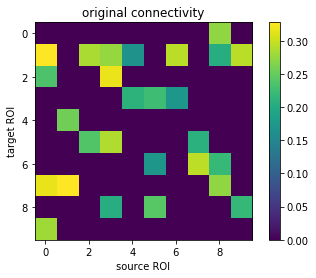

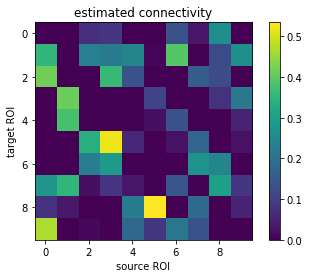

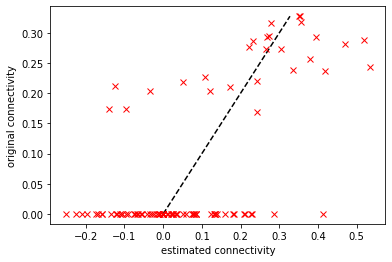

In [15]:
# moments method
mou_est2 = MOU()
mou_est2.fit(ts_sim,method='moments')

C_est2 = mou_est2.get_C()


# plots
plt.figure()
plt.imshow(C_orig,vmin=0)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('original connectivity')

plt.figure()
plt.imshow(C_est2,vmin=0)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('estimated connectivity')

plt.figure()
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.plot(C_est2,C_orig,'xr')
plt.xlabel('estimated connectivity')
plt.ylabel('original connectivity')

plt.show()

model fit for Lyapunov: 0.9532924709517882
model fit for moments: 0.8775745720511324
C_orig fit for Lyapunov (0.7710313174473481, 6.417214147175107e-21)
C_orig fit for moments (0.6449717913426656, 4.4098323109385184e-13)
C_orig fit for moments + positive constraints (0.7068549834714754, 2.0716632256028595e-16)


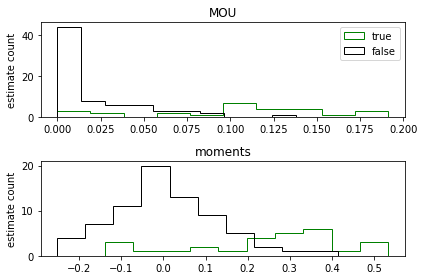

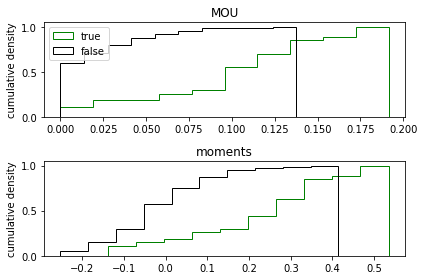

In [19]:
print('model fit for Lyapunov:',mou_est.d_fit['correlation'])
print('model fit for moments:',mou_est2.d_fit['correlation'])

print('C_orig fit for Lyapunov',stt.pearsonr(C_orig.flatten(),C_est.flatten()))
print('C_orig fit for moments',stt.pearsonr(C_orig.flatten(),C_est2.flatten()))
print('C_orig fit for moments + positive constraints',stt.pearsonr(C_orig.flatten(),np.maximum(C_est2,0).flatten()))

plt.figure()
plt.subplot(211)
plt.hist(C_est[C_orig>0],histtype='step',color='g')
plt.hist(C_est[C_orig==0],histtype='step',color='k')
plt.ylabel('estimate count')
plt.title('MOU')
plt.legend(['true', 'false'])
plt.subplot(212)
plt.hist(C_est2[C_orig>0],histtype='step',color='g')
plt.hist(C_est2[C_orig==0],histtype='step',color='k')
plt.ylabel('estimate count')
plt.title('moments')
plt.tight_layout()

plt.figure()
plt.subplot(211)
plt.hist(C_est[C_orig>0],histtype='step',cumulative=True,density=True,color='g')
plt.hist(C_est[C_orig==0],histtype='step',cumulative=True,density=True,color='k')
plt.ylabel('cumulative density')
plt.legend(['true', 'false'], loc='upper left')
plt.title('MOU')
plt.subplot(212)
plt.hist(C_est2[C_orig>0],histtype='step',cumulative=True,density=True,color='g')
plt.hist(C_est2[C_orig==0],histtype='step',cumulative=True,density=True,color='k')
plt.ylabel('cumulative density')
plt.title('moments')
plt.tight_layout()

plt.show()

## Exercise

Play with the simulation duration $T$, the number $N$ of nodes and the network density $d$ to compare the two estimation methods.